In [ ]:
## 이미지 캡셔닝 1차 모델 구축
  ## 베이스 아키텍처: Show, Attend and Tell
  ## 추가 확보 데이터: vocab(from pre-trained model)
  ## 프로세스
    ## 데이터 로드, 체크
    ## 텍스트 데이터 추가 전처리(정규화, 토큰화, 패딩)
    ## 이미지 데이터 전처리
    ## 모델 정의: CNN, Attention, LSTM
    ## 기타 사용자 정의 함수 생성(손실함수 등)
    ## 모델 컴파일 및 훈련
    ## 모델 검증(테스트 데이터 확인, 학습결과 시각화, 매트릭스 출력)

In [1]:
!pip install nltk rouge

In [2]:
## Data load

from google.colab import drive
import os

drive.mount('/content/drive')
zip_file_path = '/content/drive/My Drive/data-team3-imagecaption/train_sample_1.zip'
%mkdir 'train_sample_1'

!cp "{zip_file_path}" "/content/"

!unzip -q "/content/train_sample_1.zip" -d "/content/train_sample_1/"

print('unizipped files: ', os.listdir('/content/train_sample_1'))

Mounted at /content/drive
unizipped files:  ['IMG_0446357_person(person).jpg', 'IMG_0446336_person(person).jpg', 'IMG_0446365_person(person).jpg', 'IMG_0446253_person(person).jpg', 'IMG_0446285_person(person).jpg', 'IMG_0446300_person(person).jpg', 'IMG_0447769_person(person).jpg', 'IMG_0446289_person(person).jpg', 'IMG_0447761_person(person).jpg', 'IMG_0446344_person(person).jpg', 'IMG_0447832_person(person).jpg', 'IMG_0446277_person(person).jpg', 'IMG_0447828_person(person).jpg', 'IMG_0446271_person(person).jpg', 'IMG_0446260_person(person).jpg', 'IMG_0447767_person(person).jpg', 'IMG_0447756_person(person).jpg', 'IMG_0447788_person(person).jpg', 'IMG_0447762_person(person).jpg', 'IMG_0446293_person(person).jpg', 'IMG_0446350_person(person).jpg', 'IMG_0446331_person(person).jpg', 'IMG_0447771_person(person).jpg', 'IMG_0447759_person(person).jpg', 'IMG_0446274_person(person).jpg', 'IMG_0446266_person(person).jpg', 'IMG_0447790_person(person).jpg', 'IMG_0447809_person(person).jpg', 'IM

In [4]:
## text data additional preprocessing for model train

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re

In [73]:
df = pd.read_csv('/content/train_sample_1/train_sample_200.csv', encoding='utf-8')
df.head(2)

,id,height,width,file_name,category,sentence_en
0,446250,1920,1440,IMG_0446250_person(person).jpg,person,a man is holding an umbrella
1,446251,1920,1080,IMG_0446251_person(person).jpg,person,a man is turning on a gas stove


In [94]:
## text data preprocessing

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

def preprocess_and_tokenize(df, text_column='sentence_en'):
  def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

  start_token = '<start>'
  end_token = '<end>'
  pad_token = '<pad>'

  df['cleaned_sentence'] = df[text_column].apply(clean_text)

  tokenizer = Tokenizer(oov_token=pad_token)
  tokenizer.fit_on_texts(df['cleaned_sentence'])

  tokenizer.word_index[start_token] = len(tokenizer.word_index) + 1
  tokenizer.word_index[end_token] = len(tokenizer.word_index) + 1
  tokenizer.word_index[pad_token] = 0
  tokenizer.index_word[0] = pad_token

  sequences = tokenizer.texts_to_sequences(df['cleaned_sentence'])
  sequences = [[tokenizer.word_index[start_token]] + seq + [tokenizer.word_index[end_token]] for seq in sequences]

  max_length = max(len(sequence) for sequence in sequences)
  sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post', value=tokenizer.word_index[pad_token])

  vocab_size = len(tokenizer.word_index) + 1

  x_data_text = sequences_padded[:, :-1]
  y_data = sequences_padded[:, 1:]

  y_data_one_hot = to_categorical(y_data, num_classes=vocab_size)
  max_sequence_length = max_length - 1

  return x_data_text, y_data_one_hot, y_data, vocab_size, tokenizer, max_sequence_length


In [97]:
print(max_sequence_length)

20


In [7]:
## image data preprocessing for model train

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

image_folder = '/content/train_sample_1'

In [8]:
def process_image(file_name, target_size=(299,299)):
  image_path = os.path.join(image_folder, file_name)
  image = load_img(image_path, target_size=target_size)
  image = img_to_array(image)
  image = image.astype('float32')
  image /= 255.0
  return image

In [96]:
image_data = np.array([process_image(file_name) for file_name in df['file_name']])

x_data_text, y_data_one_hot, y_data, vocab_size, tokenizer, max_sequence_length = preprocess_and_tokenize(df)
x_data_image = image_data

In [81]:
print(image_data.shape)

(200, 299, 299, 3)


In [98]:
## train_test data split: one-hot encoding

train_image_1, test_image_1, train_sequences_1,\
 test_sequences_1, train_y_1, test_y_1 = train_test_split(x_data_image, x_data_text, y_data_one_hot, test_size=0.2, random_state=42)

In [27]:
## train_test data split: int transformed encoding

train_image_2, test_image_2, train_sequences_2,\
 test_sequences_2, train_y_2, test_y_2 = train_test_split(x_data_image, x_data_text, y_data_int, test_size=0.2, random_state=42)

In [49]:
print(train_image_1.shape)
print(train_sequences_1.shape)
print(test_image_1.shape)
print(test_sequences_1.shape)
print(train_y_1.shape)
print(test_y_1.shape)

(160, 299, 299, 3)
(160, 20)
(40, 299, 299, 3)
(40, 20)
(160, 20, 273)
(40, 20, 273)


In [50]:
print(vocab_size)

273


In [62]:
## define model(use cross-attention only)
  ## cross-attention은 그냥 attention이랑 같은거라고 보면 됨

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout
from tensorflow.keras.layers import AdditiveAttention, MultiHeadAttention, Lambda, Masking, RepeatVector, Reshape
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [51]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]

inception_resnet_model = InceptionResNetV2(include_top=False,\
                                           weights='imagenet',\
                                           pooling='avg')
inception_resnet_model.trainable = False

vocab_size = vocab_size
lstm_units = 256

image_input = Input(shape=(299,299,3))
image_features = inception_resnet_model(image_input)

sequence_input = Input(shape=(None,))

embedding = Embedding(input_dim=vocab_size,\
                      output_dim=256)(sequence_input)

bidirectional_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))

lstm_output = bidirectional_lstm(embedding)

dropout = Dropout(0.5)
lstm_output = dropout(lstm_output)

second_lstm = LSTM(lstm_units,\
                   return_sequences=True,\
                   return_state=True)
lstm_output, _, _ = second_lstm(lstm_output)

padding_mask = Lambda(create_padding_mask)(sequence_input)

image_features_dense = Dense(lstm_units)(image_features)
image_features_dense = tf.expand_dims(image_features_dense, 1)

attention = AdditiveAttention()
context_vector, attention_weights = attention([lstm_output, image_features_dense], mask=[padding_mask, None])

dense = Dense(vocab_size, activation='softmax')
output = dense(context_vector)

model = Model(inputs=[image_input, sequence_input], outputs=output)
initial_weights = model.get_weights()
model.summary()

TypeError: Cannot iterate over a Tensor with unknown first dimension.

In [18]:
## BLEU, ROUGE score metrics function

import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
nltk.download('punkt')

def calculate_bleu(references, candidates):
  score = 0
  for ref, cand in zip(references, candidates):
    ref_tokens = nltk.word_tokenize(ref.lower())
    cand_tokens = nltk.word_tokenize(cand.lower())
    score += sentence_bleu([ref_tokens], cand_tokens, weights=(0.25, 0.25, 0.25, 0.25))

  return score / len(candidates)

def calculate_rouge(references, candidates):
  rouge = Rouge()
  scores = rouge.get_scores(candidates, references, avg=True)
  return scores

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
## 학습 준비: basic model compile

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
## train basic model

history_1 = model.fit([train_image_1, train_sequences_1], train_y_1,\
                      validation_data=([test_image_1, test_sequences_1], test_y_1),\
                      epochs=50, batch_size=32, verbose=1)

Epoch 1/50
5/5 [==============================] - 38s 2s/step - loss: 2.1485 - accuracy: 0.0300 - val_loss: 2.1854 - val_accuracy: 0.0450
Epoch 2/50
5/5 [==============================] - 3s 541ms/step - loss: 1.9409 - accuracy: 0.0478 - val_loss: 2.0964 - val_accuracy: 0.0350
Epoch 3/50
5/5 [==============================] - 3s 545ms/step - loss: 1.8296 - accuracy: 0.0453 - val_loss: 2.0392 - val_accuracy: 0.0475
Epoch 4/50
5/5 [==============================] - 2s 448ms/step - loss: 1.7638 - accuracy: 0.0456 - val_loss: 2.0263 - val_accuracy: 0.0475
Epoch 5/50
5/5 [==============================] - 2s 438ms/step - loss: 1.7287 - accuracy: 0.0487 - val_loss: 2.0486 - val_accuracy: 0.0400
Epoch 6/50
5/5 [==============================] - 2s 463ms/step - loss: 1.7135 - accuracy: 0.0534 - val_loss: 1.9956 - val_accuracy: 0.0275
Epoch 7/50
5/5 [==============================] - 2s 512ms/step - loss: 1.7142 - accuracy: 0.0481 - val_loss: 1.9899 - val_accuracy: 0.0487
Epoch 8/50
5/5 [======

In [37]:
print("eager execution: ", tf.executing_eagerly())

eager execution:  True


In [57]:
print(max_sequence_length)

21


In [99]:
## model2: (cross)attention + self_attention

def create_model(vocab_size, lstm_units, max_sequence_length):

  inception_resnet_model = InceptionResNetV2(include_top=False,\
                                            weights='imagenet',\
                                            pooling='avg')
  inception_resnet_model.trainable = False

  image_input = Input(shape=(299,299,3))
  image_features = inception_resnet_model(image_input)

  sequence_input = Input(shape=(max_sequence_length,))

  embedding = Embedding(input_dim=vocab_size,\
                        output_dim=256, mask_zero=True)(sequence_input)

  bidirectional_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))

  lstm_output = bidirectional_lstm(embedding)

  dropout = Dropout(0.5)
  lstm_output = dropout(lstm_output)

  second_lstm = LSTM(lstm_units,\
                    return_sequences=True,\
                    return_state=True)
  lstm_output, _, _ = second_lstm(lstm_output)

  image_features_dense = Dense(lstm_units)(image_features)
  image_features_dense = Reshape((1, lstm_units))(image_features_dense)
  image_features_dense = Lambda(lambda x: tf.tile(x, [1, max_sequence_length, 1]))(image_features_dense)

  print("LSTM output shape: ", lstm_output.shape)
  print("image feature shape: ", image_features_dense.shape)

  attention = AdditiveAttention()
  context_vector, attention_weights = attention([lstm_output, image_features_dense], return_attention_scores=True)

  self_attention = MultiHeadAttention(num_heads=8, key_dim=lstm_units)
  self_attention_output = self_attention(query=lstm_output, value=lstm_output, key=lstm_output)

  combined_attention_output = tf.keras.layers.Concatenate(axis=-1)([context_vector, self_attention_output])

  dense = Dense(vocab_size, activation='softmax')
  output = dense(combined_attention_output)

  return Model(inputs=[image_input, sequence_input], outputs=output)


model_2 = create_model(vocab_size, 256, max_sequence_length)
initial_weights = model_2.get_weights()
model_2.summary()

LSTM output shape:  (None, 20, 256)
image feature shape:  (None, 20, 256)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 20)]                 0         []                            
                                                                                                  
 input_44 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 20, 256)              69888     ['input_45[0][0]']            
                                                                                                  
 inception_resnet_v2 (Funct  (None, 1536)                 5433673   ['input_44[0][0]']            
 ional)           

In [100]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
print(max_sequence_length)
print(train_sequences_1.shape)
print(test_sequences_1.shape)

20
(160, 20)
(40, 20)


In [102]:
## train model_2

history_2 = model_2.fit([train_image_1, train_sequences_1], train_y_1,\
                      validation_data=([test_image_1, test_sequences_1], test_y_1),\
                      epochs=30, batch_size=32, verbose=1)

Epoch 1/30
5/5 [==============================] - 40s 3s/step - loss: 4.9249 - accuracy: 0.0731 - val_loss: 4.8364 - val_accuracy: 0.0990
Epoch 2/30
5/5 [==============================] - 3s 594ms/step - loss: 4.3205 - accuracy: 0.0918 - val_loss: 4.4195 - val_accuracy: 0.0965
Epoch 3/30
5/5 [==============================] - 3s 654ms/step - loss: 4.0751 - accuracy: 0.1067 - val_loss: 4.3722 - val_accuracy: 0.0990
Epoch 4/30
5/5 [==============================] - 3s 642ms/step - loss: 3.9378 - accuracy: 0.1151 - val_loss: 4.2627 - val_accuracy: 0.1163
Epoch 5/30
5/5 [==============================] - 2s 498ms/step - loss: 3.7575 - accuracy: 0.1164 - val_loss: 4.2981 - val_accuracy: 0.1015
Epoch 6/30
5/5 [==============================] - 2s 499ms/step - loss: 3.6082 - accuracy: 0.1216 - val_loss: 4.2519 - val_accuracy: 0.1089
Epoch 7/30
5/5 [==============================] - 3s 550ms/step - loss: 3.4814 - accuracy: 0.1138 - val_loss: 4.1783 - val_accuracy: 0.1213
Epoch 8/30
5/5 [======

In [28]:
## train model_2_2: 원-핫 인코딩 대신 정수형 인코딩 y데이터로 훈련
initial_weights = model_2.get_weights()
model_2.set_weights(initial_weights)
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
history_2 = model_2.fit([train_image_2, train_sequences_2], train_y_2,\
                      validation_data=([test_image_2, test_sequences_2], test_y_2),\
                      epochs=20, batch_size=32, verbose=1)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 170.3589 - accuracy: 0.0091

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1920, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 961, in sparse_categorical_matches
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[2], expected a dimension of 1, got 273 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](IteratorGetNext:2)' with input shapes: [?,20,273].


In [ ]:
## 1차 훈련 결과 해석
  ## loss값은 처음에는 3.6이라는 높은 수치였다가, 학습 횟수를 반복할수록 감소가 됨(최종 0.1754)
  ## accuracy값은 처음에는 0.5대였다가 마지막에는 0.945로 지속적 증가
  ## val_loss값은 처음에는 2.9이고 학습이 진행될수록 감소하면서 20회차에 1.6으로 최소값, 이후 다시 증가하면서 50회차에는 2.29로 종료
    ## 왜 높게 나왔냐? 과적합 가능성이 큼; 현재는 200개 데이터로만 학습을 진행하였으므로, 학습 데이터에 과적합이 발생하여 검증 데이터를 제대로 예측하지 못했을 가능성이 큼
    ## 문장을 예측하는 모델들에서는 일반적으로 val_loss값이 비교적 클 수 밖에 없음. 라벨 1개 값만 예측하는 것이 아니기 때문에, 5개중에 2~3개는 제대로 예측했어도, 나머지 값을 예측실패하면 val_loss값이 커지므로, 애초에 불리한 구조
    ## 텍스트 생성 모델의 경우에는 BLEU 또는 ROUGE 점수를 산출하여 metrics로 사용하는 것을 추천함

In [ ]:
## BLEU, ROUGE score check

predicted_sequences = model.predict([test_image_1, test_sequences_1])

2/2 [==============================] - 6s 101ms/step


In [ ]:
index_to_word = {index: word for word, index in tokenizer.word_index.items()}

def sequences_to_text(sequences):
  text_output = []
  for sequence in sequences:
    sequence_text = []
    for word_idx in sequences:
      max_idx = np.argmax(word_idx)
      sequence_text.append(index_to_word.get(max_idx, ''))
    text_output.append(' '.join(sequence_text))
  return text_output

predicted_texts = sequences_to_text(predicted_sequences)

In [ ]:
## 원-핫 인코딩된 텍스트를 다시 문장으로 변환 function

def one_hot_to_text(one_hot_sequences, index_to_word):
  text_output = []
  for sequence in one_hot_sequences:
    sequence_text = []
    for word_vec in sequence:
      max_idx = np.argmax(word_vec)
      word = index_to_word.get(max_idx, '')
      if word:
        sequence_text.append(word)
    text_output.append(' '.join(sequence_text))
  return text_output

In [ ]:
test_y_texts = one_hot_to_text(test_y_1, index_to_word)

bleu_score = calculate_bleu(test_y_texts, predicted_texts)
rouge_score = calculate_rouge(test_y_texts, predicted_texts)

print("BLEU Score: ", bleu_score)
print("ROUGE Score: ", rouge_score)

BLEU Score:  2.578518641947444e-233
ROUGE Score:  {'rouge-1': {'r': 0.09896915584415586, 'p': 0.575, 'f': 0.16495962232847056}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.09896915584415586, 'p': 0.575, 'f': 0.16495962232847056}}


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
print(test_y_texts)

['man is looking at the blue doll on the red table', 'girl has just left the electric scooter', 'man is cutting the eggplant', 'woman is holding a egg plant', 'woman is playing with a ball', 'man is cooking', 'man lying on a bench is reading a book', 'woman is holding a book', 'are playing billiards', 'man is looking at billiard balls', 'girl prepares to catch the baseball with her left hand which is held in her right hand', 'man is searching in a bag', 'man is riding a electric scooter', 'man is sitting outdoors in a chair and using a portable fan', 'woman is holding a fan', 'woman is playing with a baseball', 'man is holding a big doll and looking at it', 'man is cooking', 'man is looking at a small frying pan', 'woman is eating something with chopsticks', 'man is playing billiards', 'man is looking at the measuring instrument to check the temperature or humidity', 'woman is playing screen golf', 'man is folding the yellow umbrella', 'man who grabs the cutting board with is left hand

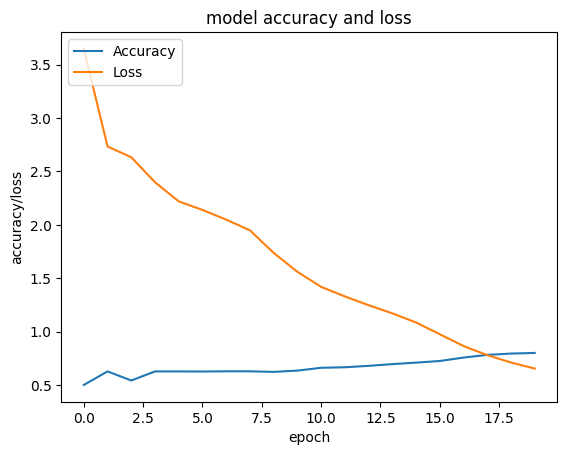

In [ ]:
## visualization for train process

import matplotlib.pyplot as plt

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

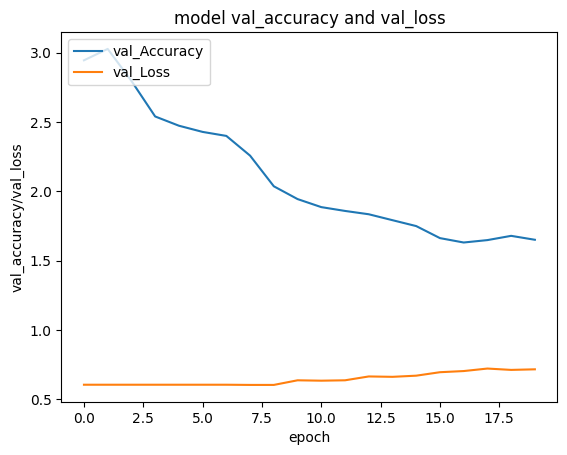

In [ ]:
plt.plot(history_1.history['val_loss'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model val_accuracy and val_loss')
plt.ylabel('val_accuracy/val_loss')
plt.xlabel('epoch')
plt.legend(['val_Accuracy', 'val_Loss'], loc='upper left')
plt.show()

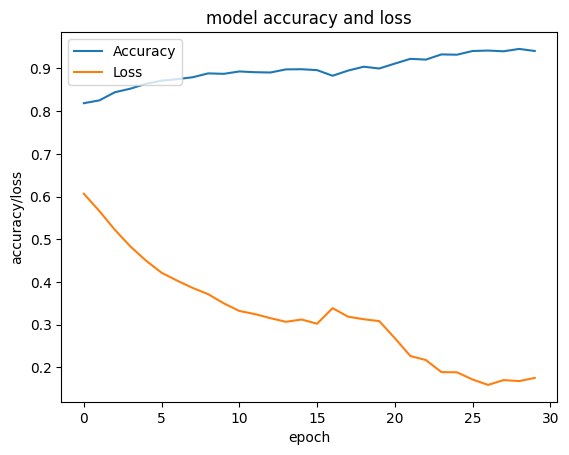

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [ ]:
## fine tuining 1: end with '0'token sequence for y_data

In [ ]:
sequences_offset_0 = np.hstack([sequences_padded[:, 1:], np.zeros((sequences_padded.shape[0], 1))])

x_data_image = image_data
x_data_text = sequences_padded
y_data_offset_0 = sequences_offset_0

train_image_2, test_image_2, train_sequences_2,\
 test_sequences_2, train_y_2, test_y_2 = train_test_split(x_data_image, x_data_text, y_data_offset_0, test_size=0.2, random_state=42)

print(train_image_2.shape)
print(train_sequences_2.shape)
print(test_image_2.shape)
print(test_sequences_2.shape)
print(train_y_2.shape)
print(test_y_2.shape)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.set_weights(initial_weights)

In [ ]:
history_case2_1 = model.fit([train_image_1, train_sequences_1], train_y_1,\
                      validation_data=([test_image_1, test_sequences_1], test_y_1),\
                      epochs=30, batch_size=32, verbose=1)

In [ ]:
## fine tuning 2: end with '<end>' token sequence for y_data

df['with_end_token'] = df['cleaned_sentence'].apply(lambda x: x + ' <end>')

max_length = max(len(sequence) for sequence in sequences)
sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

tokenizer.fit_on_texts(df['with_end_token'])
sequences = tokenizer.texts_to_sequences(df['with_end_token'])
sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

x_data_image = image_data
x_data_text = sequences_padded[:, :-1]
y_data_offset_end = np.hstack([sequences_padded[:, 1:], np.zeros((sequences_padded.shape[0], 1))])


train_image_3, test_image_3, train_sequences_3,\
 test_sequences_3, train_y_3, test_y_3 = train_test_split(x_data_image, x_data_text, y_data_offset_end, test_size=0.2, random_state=42)

print(train_image_3.shape)
print(train_sequences_3.shape)
print(test_image_3.shape)
print(test_sequences_3.shape)
print(train_y_3.shape)
print(test_y_3.shape)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.set_weights(initial_weights)

In [ ]:
history_case3_1 = model.fit([train_image_1, train_sequences_1], train_y_1,\
                      validation_data=([test_image_1, test_sequences_1], test_y_1),\
                      epochs=30, batch_size=32, verbose=1)